### important path resolutions:

In [10]:
import sys
sys.path.append('/project/src/libs')
sys.path.append('/project/src/libs/SNNnanosenpy')
import SNNnanosenpy as snnSempy


### Használt függvények:

In [ ]:
import numpy
import torch

##### Download dataset if does not exist and  a small function to check data by label:

In [11]:
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS

# Define a function to get the nth instance of a specific label
def get_nth_instance(dataset, target_label, n):
    count = 0
    for data in dataset:
        waveform, sample_rate, label, speaker_id, utterance_number = data
        if label == target_label:
            count += 1
            if count == n:
                return waveform, sample_rate, label, speaker_id, utterance_number
    return None  # If the nth instance is not found

# Initialize the dataset
dataset = SPEECHCOMMANDS(root="/project/data/GSC", download=True)

# # # Access the first data point
# waveform, sample_rate, label, speaker_id, utterance_number = dataset[0]

# # # Example usage: Retrieve the 3rd instance of the label "yes"
# n = 3
# target_label = "yes"
# nth_data_point = get_nth_instance(dataset, target_label, n)

# # Print the details of the nth instance
# if nth_data_point:
#     waveform, sample_rate, label, speaker_id, utterance_number = nth_data_point
#     print(f"{n}rd instance of '{target_label}':")
#     print(f"Waveform shape: {waveform.shape}")
#     print(f"Sample rate: {sample_rate}")
#     print(f"Label: {label}")
#     print(f"Speaker ID: {speaker_id}")
#     print(f"Utterance Number: {utterance_number}")
# else:
#     print(f"No {n}th instance found with the label '{target_label}'.")

##### Functions:

In [13]:
import pickle

# Define your hyperparameters
hyperparams = {
    'batch_size': 128,
    'sf_threshold': 150,
    'hop_length': 20,
    'f_min': 200,
    'f_max': 16000,
    'n_mels': 22,
    'n_fft': 512,
    'wav_file_samples': 16000,
    'log_spectral_feature': True,
    'spectral_feature': "Mel",  # "Mel" or "MFCC"
    'timestep': calculate_num_frames(16000, 512, 20, center=True, show=True)
}

# Save hyperparameters to a file
with open('hyperparams.pkl', 'wb') as f:
    pickle.dump(hyperparams, f)

batch_size = hyperparams['batch_size']
sf_threshold = hyperparams['sf_threshold']
hop_length = hyperparams['hop_length']
f_min = hyperparams['f_min']
f_max = hyperparams['f_max']
n_mels = hyperparams['n_mels']
n_fft = hyperparams['n_fft']
wav_file_samples = hyperparams['wav_file_samples']
log_spectral_feature = hyperparams['log_spectral_feature']
spectral_feature = hyperparams['spectral_feature']
timestep = hyperparams['timestep']

a spektrogram hossza (= lehet a timestep): 801


a spektrogram hossza (= lehet a timestep): 801
f_min: 200, f_max: 16000, n_mels: 22, spectral_feature: Mel, timestep or spectrogram data length 801
tensor: torch.Size([1, 44, 632])


/home/workbench/.local/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (22) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


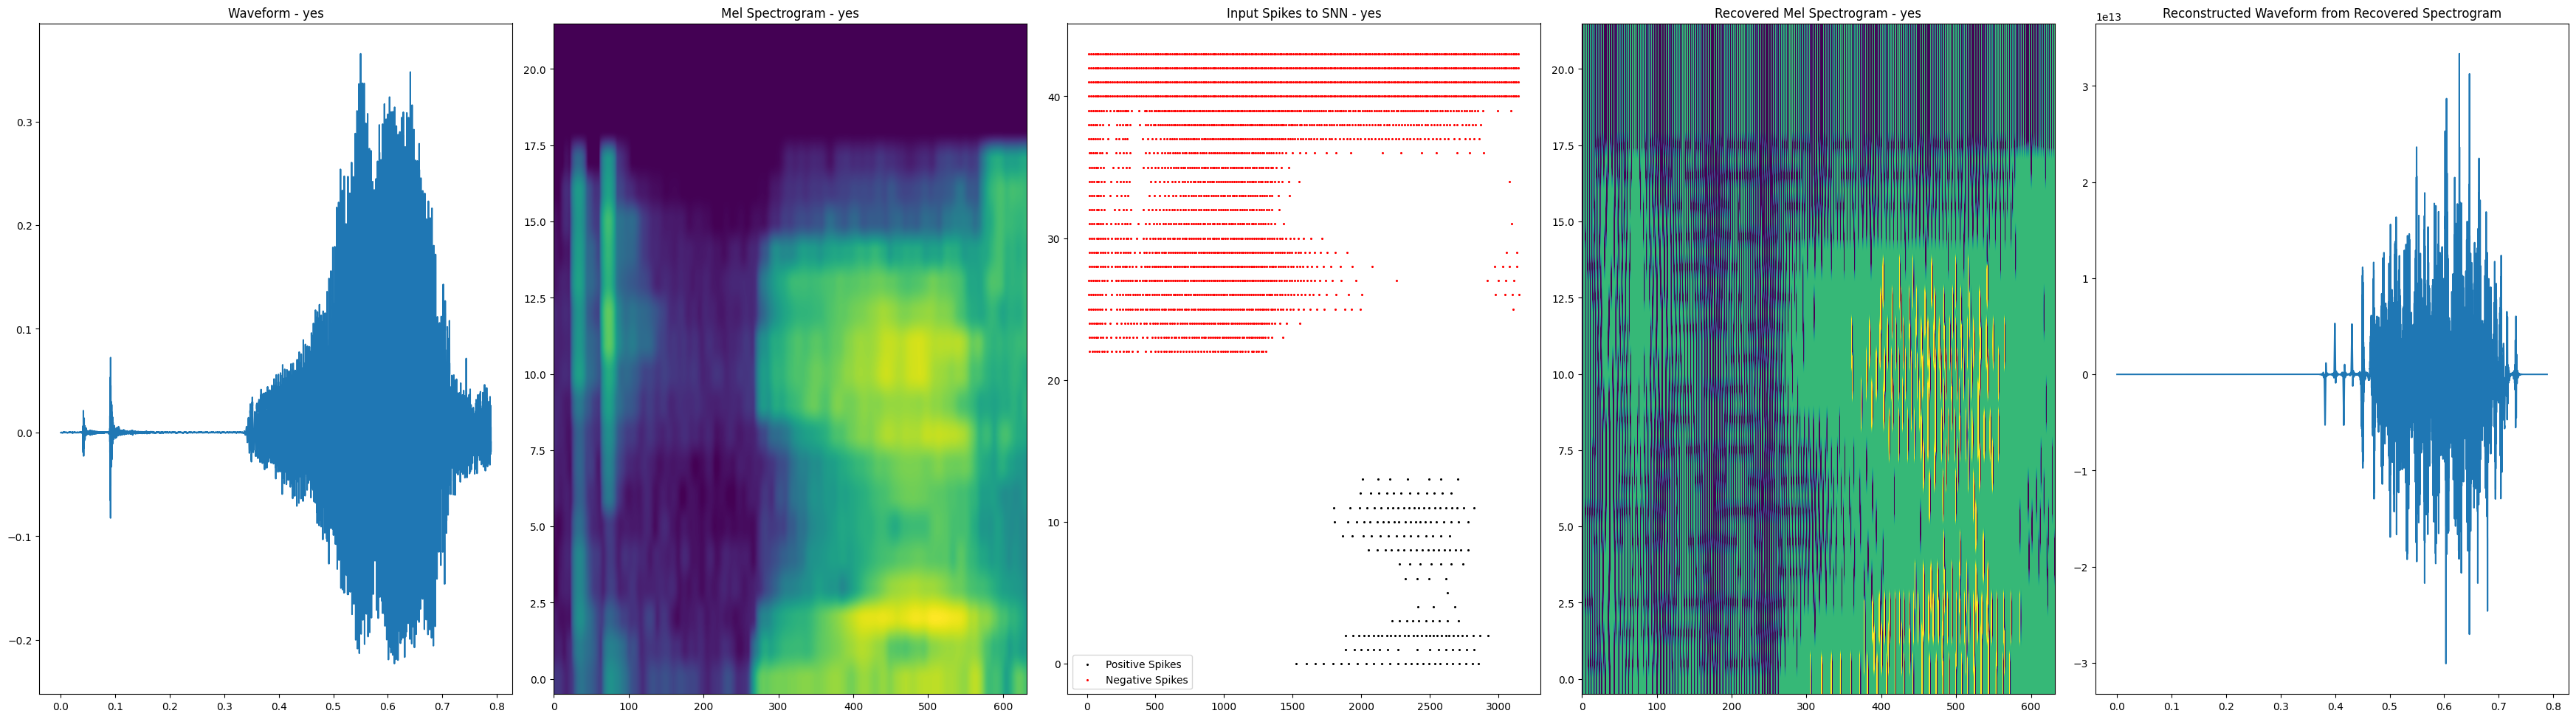

Original Waveform:


Recovered Waveform:


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
from torchaudio.transforms import AmplitudeToDB, GriffinLim
import torchaudio.transforms as T
import SNNnanosenpy as snnnspy
from IPython.display import Audio, display
import ipywidgets as widgets
import matplotlib.gridspec as gridspec

def calculate_num_frames(L, n_fft, hop_length, center=True, show=False):
    """
    Calculate the number of time frames in the spectrogram.

    Args:
    - L: Length of the .wav input signal (samples).
    - n_fft: Window size.
    - hop_length: Hop length.
    - center: Whether padding is applied to the input signal (default: True).

    Returns:
    - Number of time frames.
    """
    if center:
        # Calculate the padded length
        padded_length = L + 2 * (n_fft // 2)
        num_frames = ((padded_length - n_fft) // hop_length) + 1
    else:
        num_frames = ((L - n_fft) // hop_length) + 1
    if show:
        print("a spektrogram hossza (= lehet a timestep):",num_frames)
    return num_frames

# Function to reverse step forward encoding
def reverse_step_forward_encoding(base_sig, pos_sig, neg_sig, thr):
    spikes = pos_sig - neg_sig
    batch_reconstructed = torch.zeros_like(base_sig)
    batch_reconstructed[..., 0] = base_sig[..., 0]
    for t in range(1, base_sig.shape[-1]):
        batch_reconstructed[..., t] = base_sig[..., t] + spikes[..., t] * thr
    return batch_reconstructed

# Function to get the nth file of a specific label
def get_nth_file_of_label(base_path, target_label, n):
    label_dir = os.path.join(base_path, target_label)
    files = [f for f in os.listdir(label_dir) if f.endswith('.wav')]
    if n <= len(files):
        return os.path.join(label_dir, files[n - 1])
    else:
        return None

# Function to process and plot the nth instance of a label
def process_and_plot_nth_instance_of_label(label, instance_index, spectral_feature="Mel", threshold=50, hop_length=10, log_scale=True, show_spike_analysis=False, freq_bin=0, n_mels=22, f_min=200, f_max=16000, n_fft=512):
    base_path = '/project/data/GSC/SpeechCommands/speech_commands_v0.02'
    
    # Get the nth file for the given label
    file_path = get_nth_file_of_label(base_path, label, instance_index)
    
    if not file_path:
        print(f"Instance {instance_index} of label '{label}' not found.")
        return
    
    # Load the audio file
    waveform, sample_rate = torchaudio.load(file_path)
    time = np.linspace(0, waveform.size(1) / sample_rate, num=waveform.size(1))

    # Apply the chosen spectral transformation
    if spectral_feature == "Mel":
        transform = T.MelSpectrogram(sample_rate=16000, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, f_min=f_min, f_max=f_max)
    elif spectral_feature == "MFCC":
        transform = T.MFCC(sample_rate=16000, n_mfcc=n_mels, melkwargs={"n_fft": n_fft, "hop_length": hop_length, "n_mels": n_mels, "f_min": f_min, "f_max": f_max})
    else:
        raise ValueError("Invalid spectral_feature. Supported values are 'Mel' and 'MFCC'.")

    spectral_tensor = transform(waveform)

    # Apply logarithmic scale if needed
    if log_scale:
        spectral_tensor = AmplitudeToDB(stype='power', top_db=80)(spectral_tensor)

    vmin, vmax = spectral_tensor.min().item(), spectral_tensor.max().item()

    # Create plots
    fixed_width_in_inches = 35  # Adjust this width to your preference

    if show_spike_analysis:
        fig = plt.figure(figsize=(fixed_width_in_inches, 15))
        gs = gridspec.GridSpec(3, 5, height_ratios=[1, 0.5, 0.5])  # 3 rows, 5 columns
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax3 = fig.add_subplot(gs[0, 2])
        ax4 = fig.add_subplot(gs[0, 3])
        ax5 = fig.add_subplot(gs[0, 4])
        ax6 = fig.add_subplot(gs[1, :])
        ax7 = fig.add_subplot(gs[2, :])
    else:
        fig = plt.figure(figsize=(fixed_width_in_inches, 10))
        gs = gridspec.GridSpec(1, 5)  # 1 row, 5 columns
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax3 = fig.add_subplot(gs[0, 2])
        ax4 = fig.add_subplot(gs[0, 3])
        ax5 = fig.add_subplot(gs[0, 4])

    # Plot the original waveform
    ax1.plot(time, waveform.squeeze().numpy())
    ax1.set_title(f'Waveform - {label}')

    # Plot the chosen spectral feature
    spectral_spec = spectral_tensor.squeeze().numpy()
    img = ax2.imshow(spectral_spec, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
    ax2.set_title(f'{spectral_feature} Spectrogram - {label}')

    # Plot spikes
    csum = torch.cumsum(spectral_tensor, dim=-1)
    base_cum, pos_cum, neg_cum = snnnspy.step_forward_encoding(csum, threshold, neg=True)
    tensor = torch.cat((pos_cum, neg_cum), dim=1)
    print("tensor:",tensor.shape)

    pos_spikes_x, pos_spikes_y = np.where(tensor[0, :, :].t() > 0)
    neg_spikes_x, neg_spikes_y = np.where(tensor[0, :, :].t() < 0)

    ax3.scatter(pos_spikes_x * 5, pos_spikes_y, s=1.5, c="black", label="Positive Spikes")
    ax3.scatter(neg_spikes_x * 5, neg_spikes_y, s=1.5, c="red", label="Negative Spikes")
    ax3.set_title(f'Input Spikes to SNN - {label}')
    ax3.legend()

    # Plot the recovered waveform
    recovered_csum = reverse_step_forward_encoding(base_cum, pos_cum, neg_cum, threshold)
    prepend_tensor = torch.zeros((recovered_csum.shape[0], recovered_csum.shape[1], 1), dtype=recovered_csum.dtype, device=recovered_csum.device)
    recovered_spectral_tensor = torch.diff(recovered_csum, prepend=prepend_tensor, dim=2)

    recovered_spectral_spec = recovered_spectral_tensor.squeeze().cpu().numpy()
    img_recovered = ax4.imshow(recovered_spectral_spec, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
    ax4.set_title(f'Recovered {spectral_feature} Spectrogram - {label}')

    if log_scale:
        recovered_spectral_tensor_amplitude = torch.pow(10.0, recovered_spectral_tensor / 10.0)
    else:
        recovered_spectral_tensor_amplitude = recovered_spectral_tensor

    stft_size = n_fft // 2 + 1
    recovered_spectrogram = torch.nn.functional.interpolate(recovered_spectral_tensor_amplitude.unsqueeze(0), size=(stft_size, recovered_spectral_tensor.shape[-1]), mode='bilinear', align_corners=False).squeeze(0)

    InverseSTFT_transform = GriffinLim(n_fft=n_fft, hop_length=hop_length)
    recovered_waveform = InverseSTFT_transform(recovered_spectrogram)

    time_recovered = np.linspace(0, recovered_waveform.size(1) / sample_rate, num=recovered_waveform.size(1))
    ax5.plot(time_recovered, recovered_waveform.squeeze().numpy())
    ax5.set_title('Reconstructed Waveform from Recovered Spectrogram')

    plt.tight_layout()
    plt.show()

    print("Original Waveform:")
    display(Audio(waveform.squeeze().numpy(), rate=sample_rate))

    print("Recovered Waveform:")
    display(Audio(recovered_waveform.squeeze().numpy(), rate=sample_rate))

# DEFINE HYPERPARAMETERS HERE and Check Resulting Encoding:

batch_size = 128
sf_threshold=150
hop_length = 20
f_min=200
f_max=16000
n_mels=22
n_fft=512
wav_file_samples=16000
log_spectral_feature=True
spectral_feature="Mel" #"Mel" or "MFCC"
timestep= calculate_num_frames(wav_file_samples, n_fft, hop_length, center=True, show=True)
print(f"f_min: {f_min}, f_max: {f_max}, n_mels: {n_mels}, spectral_feature: {spectral_feature}, timestep or spectrogram data length {timestep}")

process_and_plot_nth_instance_of_label('yes', 3,  spectral_feature=spectral_feature, threshold=sf_threshold, hop_length=hop_length, 
                                       log_scale=log_spectral_feature, show_spike_analysis=False, 
                                       freq_bin=0, n_mels=n_mels, f_min=f_min, f_max=f_max, n_fft=n_fft)

##### Define Global variables and check resulting Encoding:

tensor: torch.Size([1, 44, 801])


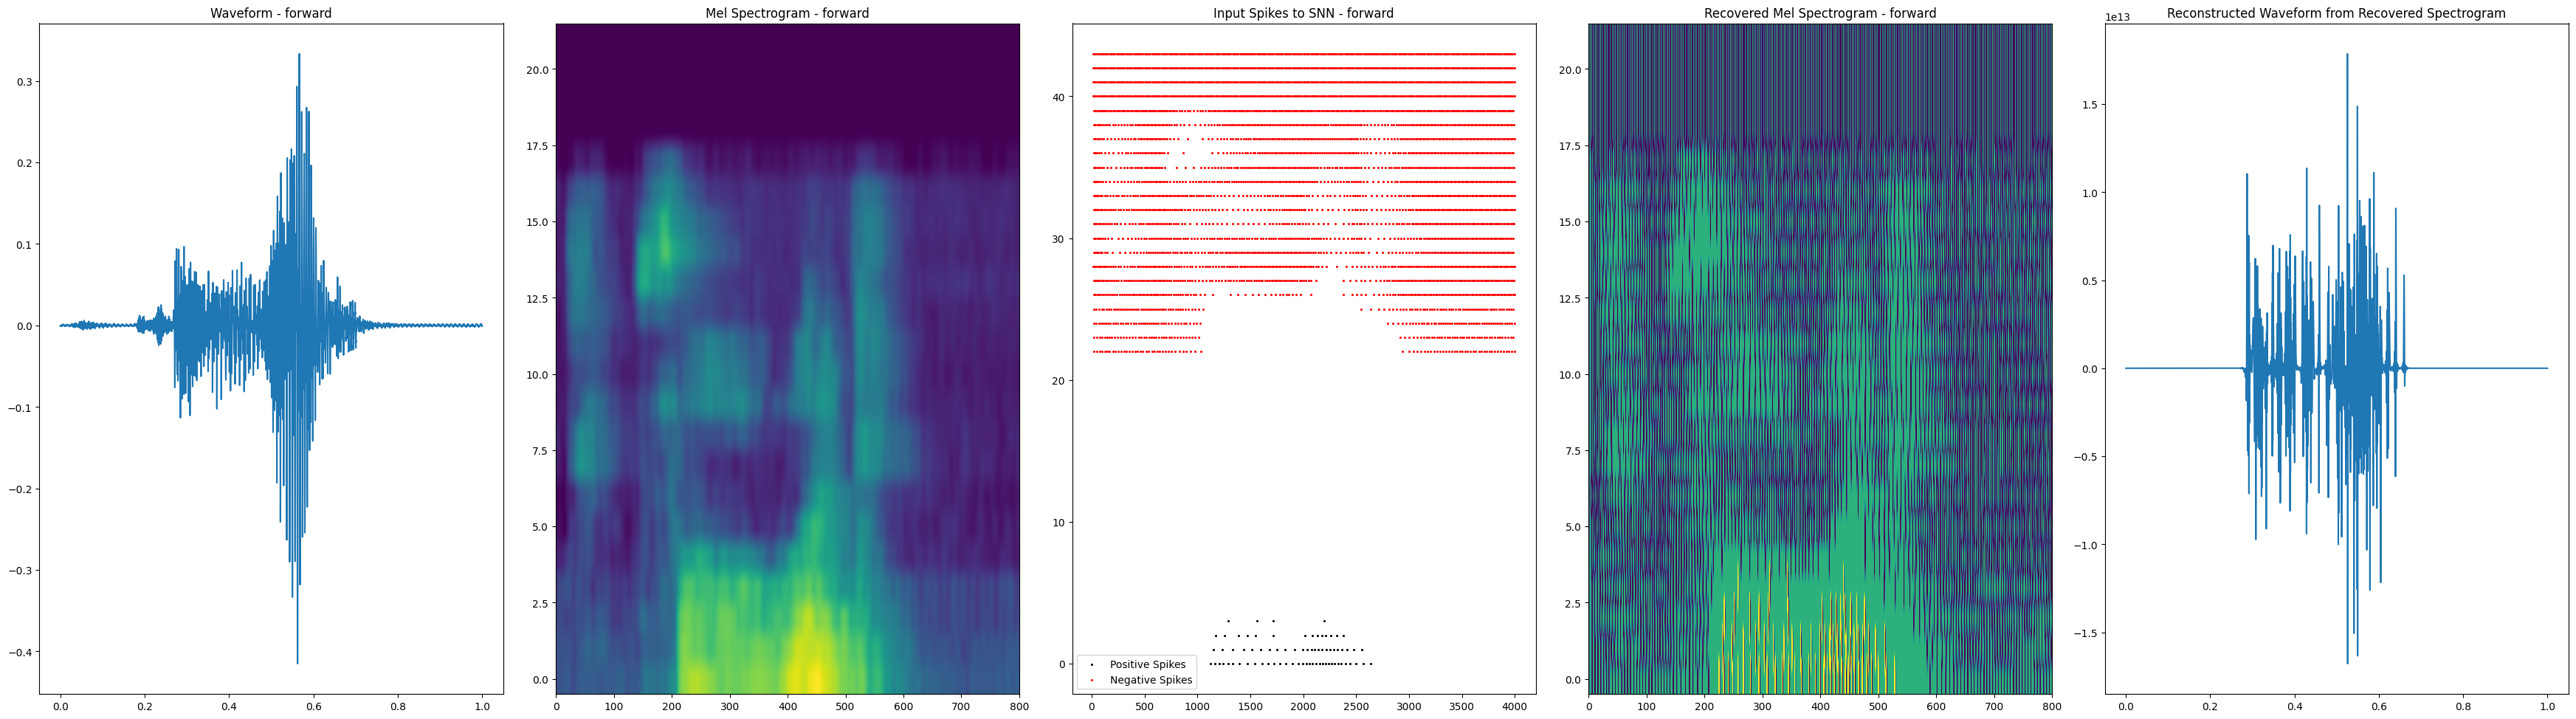

Original Waveform:


Recovered Waveform:


In [14]:
# DEFINE HYPERPARAMETERS HERE:

# batch_size = 128
# sf_threshold=150
# hop_length = 20
# f_min=200
# f_max=16000
# n_mels=22
# n_fft=512
# wav_file_samples=16000
# log_spectral_feature=True
# spectral_feature="Mel" #"Mel" or "MFCC"
# timestep= calculate_num_frames(wav_file_samples, n_fft, hop_length, center=True, show=True)
# print(f"f_min: {f_min}, f_max: {f_max}, n_mels: {n_mels}, spectral_feature: {spectral_feature}, timestep or spectrogram data length {timestep}")

process_and_plot_nth_instance_of_label('forward', 20,  spectral_feature=spectral_feature, threshold=sf_threshold, hop_length=hop_length, 
                                       log_scale=log_spectral_feature, show_spike_analysis=False, 
                                       freq_bin=0, n_mels=n_mels, f_min=f_min, f_max=f_max, n_fft=n_fft)

##### Making the train_set and test_set:

In [1]:
from SNNnanosenpy import SubsetSC,get_unique_labels
def prepare_datasets(get_labels=False, check_labels=False):
    """
    Prepare the training and testing datasets.

    Parameters:
    - check_labels (bool): If True, prints unique labels from the training set.

    Returns:
    - train_set: Training dataset.
    - test_set: Testing dataset.
    - target_labels: List of target labels.
    """

    data_path="/project/data/GSC/"
    # Create training and testing split of the data
    # train_set = SubsetSC(directory="custom/data/path", subset="training", download=False)
    train_set = SubsetSC(directory=data_path, subset="training", download=False)
    test_set = SubsetSC(directory=data_path, subset="testing", download=False)

    # Predefined target labels
    target_labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward',
                     'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on',
                     'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up',
                     'visual', 'wow', 'yes', 'zero']
    
    if get_labels:
        target_labels = get_unique_labels(train_set)
    if check_labels:
        print("the target labels are:", target_labels)

    return train_set, test_set, target_labels
#execute above func:    
train_set, test_set, target_labels = prepare_datasets(check_labels=False)

ModuleNotFoundError: No module named 'SNNnanosenpy'

##### Making custom_collate to pre-process data:

In [17]:
import torch
import torchaudio.transforms as T
import SNNnanosenpy as snnnspy

def custom_collate_fn(batch, spectral_feature, hop_length, n_mels, f_min, f_max, log_spectral_feature, threshold):
    tensors, targets = [], []

    for waveform, _, label, *_ in batch:
        tensors.append(waveform)
        targets.append(snnnspy.label_to_index(label, target_labels))

    #print("1: Number of tensors:", len(tensors))
    
    # Pad the sequence of tensors
    tensors = snnnspy.pad_sequence(tensors)
    #print("2: Padded tensors shape:", tensors.shape)

    # At this point, tensors is already a single tensor, so no need to stack
    # Apply the chosen spectral transformation to the entire batch
    if spectral_feature == "Mel":
        transform = T.MelSpectrogram(sample_rate=16000, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, f_min=f_min, f_max=f_max)
    elif spectral_feature == "MFCC":
        transform = T.MFCC(sample_rate=16000, n_mfcc=n_mels, melkwargs={"n_fft": n_fft, "hop_length": hop_length, "n_mels": n_mels, "f_min": f_min, "f_max": f_max})
    else:
        raise ValueError("Invalid spectral_feature. Supported values are 'Mel' and 'MFCC'.")

    # Apply the transformation directly to the batch tensor
    spectral_tensor = transform(tensors)
    #print("3: Spectral tensor shape:", spectral_tensor.shape)

    # Apply logarithmic scale if needed
    if log_spectral_feature:
        spectral_tensor = AmplitudeToDB(stype='power', top_db=80)(spectral_tensor)
    
    # Apply cumulative sum and step forward encoding to the cumulative sum tensor
    csum = torch.cumsum(spectral_tensor, dim=-1)
    base_cums, pos_accum, neg_accum = snnnspy.step_forward_encoding(csum, threshold, neg=True)

    # Concatenate positive and negative accumulated signals
    tensors = torch.cat((pos_accum, neg_accum), dim=2)
    #print("Final tensor shape:", tensors.shape)

    targets = torch.stack(targets)
    neuron_number = tensors.shape[2]
    return tensors, targets, neuron_number,base_cums




##### Based on preprocessing collate function make loaders, set here batc_size, and shuffle:

In [18]:
# Assuming you have already imported the necessary modules and defined your train_set
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    # collate_fn=custom_collate_fn(),
    collate_fn=lambda batch: custom_collate_fn(batch, spectral_feature=spectral_feature,hop_length=hop_length, n_mels=n_mels, f_min=f_min, f_max=f_max,log_spectral_feature=log_spectral_feature,threshold=sf_threshold),
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    # drop_last=True,    
    # collate_fn=custom_collate_fn(),
    collate_fn=lambda batch: custom_collate_fn(batch, spectral_feature=spectral_feature,hop_length=hop_length,  n_mels=n_mels, f_min=f_min, f_max=f_max, log_spectral_feature=log_spectral_feature,threshold=sf_threshold),
)


sample_batch = next(iter(train_loader))
sample_batch_data = sample_batch[0]  # The spike data
sample_batch_base_cum = sample_batch[3]  # The base_cum from collate function
print("sample_batch.shape:",len(sample_batch))
print(f'{sample_batch[0].shape},{sample_batch[1].shape},{sample_batch[2]}')
# sample_batch.shape: 3 for print("sample_batch.shape:",len(sample_batch))
# torch.Size([64, 1, 80, 201]),torch.Size([64]),80 for command print(f'{sample_batch[0].shape},{sample_batch[1].shape},{sample_batch[2]}')
# Assuming you have train_set and other necessary variables defined 
# sample_batch = next(iter(torch.utils.data.DataLoader(train_set, batch_size=1, collate_fn=custom_collate_fn)))
neuron_number = sample_batch[2]
print("neuron_number:", neuron_number)
print("test_loader:", len(test_loader), "+ train_loader = :", len(train_loader), "=", len(test_loader) + len(train_loader))
print("test_loader*batch_size:", len(test_loader)*batch_size, "+ train_loader*batch_size = :", len(train_loader)*batch_size, "=", len(test_loader)*batch_size + len(train_loader)*batch_size)
print("test_set:", len(test_set), "+ train_set = :", len(train_set), "=", len(test_set) + len(train_set))
print("sample_batch[0].shape:",sample_batch[0].shape, sample_batch[1][0], sample_batch[2])


sample_batch.shape: 4
torch.Size([128, 1, 44, 801]),torch.Size([128]),44
neuron_number: 44
test_loader: 86 + train_loader = : 663 = 749
test_loader*batch_size: 11008 + train_loader*batch_size = : 84864 = 95872
test_set: 11005 + train_set = : 84843 = 95848
sample_batch[0].shape: torch.Size([128, 1, 44, 801]) tensor(32) 44


Spike data shape: torch.Size([128, 1, 44, 801])
n_mels: 22
Spectral feature: Mel
Number of samples in the waveform: 16000
pos_spikes: torch.Size([128, 1, 22, 801])
neg_spikes: torch.Size([128, 1, 22, 801])


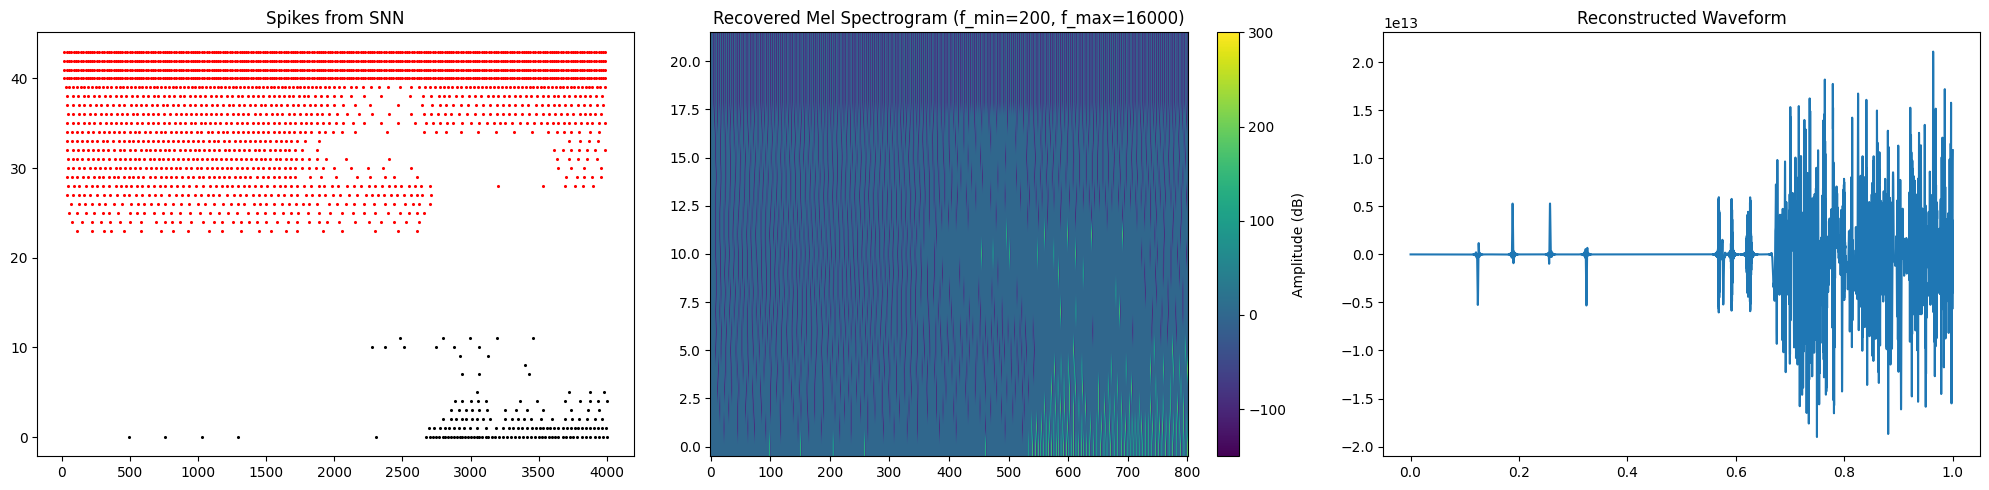

Recovered Waveform:


In [19]:
def reconstruct_from_spikes(spike_data,base_cum, spectral_feature="Mel", n_mels=22, threshold=50, hop_length=10, log_scale=True, n_fft=512, f_min=200, f_max=16000, num_samples=16000, sample_index=0):
    # Assuming spike_data has shape [batch_size, 1, 44, time_steps]
    # Split the concatenated spikes into positive and negative
    pos_spikes = spike_data[:, :, :n_mels, :]  # Positive spikes
    neg_spikes = spike_data[:, :, n_mels:, :]  # Negative spikes

    print("Spike data shape:", spike_data.shape)  # Should be [batch_size, 1, 44, time_steps]
    print("n_mels:", n_mels)
    print("Spectral feature:", spectral_feature)
    print("Number of samples in the waveform:", num_samples)
    print("pos_spikes:", pos_spikes.shape)
    print("neg_spikes:", neg_spikes.shape)

    # Reconstruct the cumulative sum from the spikes
    # base_cum = torch.zeros_like(pos_spikes)  # Initialize base cumulative tensor
    recovered_csum = reverse_step_forward_encoding(base_cum, pos_spikes, neg_spikes, threshold)

    # Recover the spectrogram by taking the difference along the time axis
    prepend_tensor = torch.zeros((recovered_csum.shape[0], recovered_csum.shape[1], recovered_csum.shape[2], 1), dtype=recovered_csum.dtype, device=recovered_csum.device)
    recovered_spectral_tensor = torch.diff(recovered_csum, prepend=prepend_tensor, dim=3)

    if log_scale:
        recovered_spectral_tensor_amplitude = torch.pow(10.0, recovered_spectral_tensor / 10.0)
    else:
        recovered_spectral_tensor_amplitude = recovered_spectral_tensor

    if spectral_feature == "Mel":
        stft_size = n_fft // 2 + 1
        recovered_spectrogram = torch.nn.functional.interpolate(
            recovered_spectral_tensor_amplitude,  # Removed unsqueeze to keep original spatial dimensions
            size=(stft_size, recovered_spectral_tensor.shape[-1]), 
            mode='bilinear', align_corners=False
        ).squeeze(1)  # Remove the extra channel dimension after interpolation

    elif spectral_feature == "MFCC":
        recovered_spectrogram = recovered_spectral_tensor_amplitude.squeeze(1)

    # Apply GriffinLim to recover the waveform for Mel
    if spectral_feature == "Mel":
        InverseSTFT_transform = GriffinLim(n_fft=n_fft, hop_length=hop_length)
        recovered_waveform = InverseSTFT_transform(recovered_spectrogram[sample_index])
    else:
        # Placeholder for MFCC to waveform conversion (more complex and typically not done)
        recovered_waveform = recovered_spectrogram[sample_index].mean(dim=0)  # Simplified placeholder

    time_recovered = np.linspace(0, num_samples / 16000, num=recovered_waveform.size(-1))  # Assuming 16kHz sample rate

    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    # Plot the recovered spectrogram (selecting one from the batch)
    recovered_spectral_spec = recovered_spectral_tensor[sample_index].squeeze().cpu().numpy()
    vmin, vmax = recovered_spectral_spec.min(), recovered_spectral_spec.max()
    ax[1].imshow(recovered_spectral_spec, aspect='auto', origin='lower', vmin=vmin, vmax=vmax, cmap='viridis')
    ax[1].set_title(f'Recovered {spectral_feature} Spectrogram (f_min={f_min}, f_max={f_max})')
    # Add color bar to the spectrogram plot
    # After plotting the recovered spectrogram
    img = ax[1].imshow(recovered_spectral_spec, aspect='auto', origin='lower', vmin=vmin, vmax=vmax, cmap='viridis')
    
    # Add color bar to the spectrogram plot
    fig.colorbar(img, ax=ax[1], orientation='vertical', label='Amplitude (dB)')

    # Adjust the y-coordinates for negative spikes
    pos_spikes_x, pos_spikes_y = np.where(pos_spikes[sample_index, 0, :, :].t() > 0)
    neg_spikes_x, neg_spikes_y = np.where(neg_spikes[sample_index, 0, :, :].t() < 0)
    neg_spikes_y += n_mels  # Shift negative spikes below the positive ones
    ax[0].scatter(pos_spikes_x * 5, pos_spikes_y, s=1.5, c="black", label="Positive Spikes")
    ax[0].scatter(neg_spikes_x * 5, neg_spikes_y, s=1.5, c="red", label="Negative Spikes")
    ax[0].set_title(f'Spikes from SNN')

    # Plot the reconstructed waveform
    ax[2].plot(time_recovered, recovered_waveform.squeeze().numpy())
    ax[2].set_title('Reconstructed Waveform')

    plt.tight_layout()
    plt.show()

    # Play the recovered waveform
    print("Recovered Waveform:")
    display(Audio(recovered_waveform.squeeze().numpy(), rate=16000))

# sf_threshold=50
# hop_length = 10
# f_min=200
# f_max=16000
# n_mels=22
# n_fft=512
# wav_file_samples=16000
# log_spectral_feature=True
# spectral_feature="Mel" #"Mel" or "MFCC"


# Example usage:
# Assuming sample_batch is the input batch from your DataLoader
reconstruct_from_spikes(sample_batch_data,sample_batch_base_cum, spectral_feature=spectral_feature, n_mels=n_mels, threshold=sf_threshold, hop_length=hop_length, log_scale=log_spectral_feature, n_fft=n_fft, f_min=f_min, f_max=f_max, num_samples=wav_file_samples, sample_index=10)




# Read and Encode dataset:

# Check GPU:

In [20]:
import importlib
importlib.reload(snnnspy)

<module 'SNNnanosenpy' from '/project/src/libs/SNNnanosenpy/__init__.py'>

In [21]:
# dataloader arguments
dtype = torch.float
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
# device = torch.device("cuda")
print("device is:",device)
print("torch.cuda.is_available?",torch.cuda.is_available())
print("torch.version",torch.version.cuda)

device is: cuda
torch.cuda.is_available? True
torch.version 12.4


### Define net hyperparameters:

In [22]:
# # GLOBALS:
# tresholdLIF=0.3
# betaLIF = 0.6
# #timestep = snnnspy.calculate_num_frames(L=16000, n_fft=400, hop_length=hop_length, center=True)
# # timestep = 201 after cmd: print("timestep:", timestep)
# # parameters that are specific to one emulation and have effects only on those:
# #defining net model:
# num_hidden = 256
# num_outputs = 35
# print("tresholdLIF:",tresholdLIF,"betaLIF:",betaLIF,"timestep:",timestep)

In [23]:
import pickle

# # Define all your hyperparameters
# hyperparams = {
#     'num_inputs': neuron_number,
#     'num_hidden': 256, 
#     'num_outputs': 35,
#     'betaLIF': 0.6,
#     'tresholdLIF': 0.3,
#     'learning_rate': 2e-4,
#     'batch_size': batch_size,
#     'num_epochs': 10,
#     # Add other hyperparameters you use
# }

additional_hyperparams = {
    'num_inputs': neuron_number,
    'num_hidden': 256, 
    'num_outputs': 35,
    'betaLIF': 0.6,
    'tresholdLIF': 0.3,
    'learning_rate': 2e-4,
    'batch_size': batch_size,
    'num_epochs': 10,
}

# Update the original hyperparams dictionary with the new ones
hyperparams.update(additional_hyperparams)


# Directly assign the hyperparameters to variables
num_inputs = hyperparams['num_inputs']
num_hidden = hyperparams['num_hidden']
num_outputs = hyperparams['num_outputs']
betaLIF = hyperparams['betaLIF']
tresholdLIF = hyperparams['tresholdLIF']
learning_rate = hyperparams['learning_rate']
batch_size = hyperparams['batch_size']
num_epochs = hyperparams['num_epochs']

# Define NET:

In [24]:
# dataloader arguments
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("If not what you want check what kernel you have. device is now:",device)

If not what you want check what kernel you have. device is now: cuda


In [25]:
# https://snntorch.readthedocs.io/en/latest/quickstart.html
from snntorch import utils
from snntorch import surrogate
import snntorch as snn
import torch.nn as nn

num_inputs = neuron_number
# below moved to GLOBALS:
# num_hidden = 256
# num_outputs = 35

# betaLIF = 0.9 is given as GLOBALS
# tresholdLIF =0.5 is given as GLOBALS
spike_grad = surrogate.fast_sigmoid() # fast sigmoid surrogate gradient


# Initialize network
net = nn.Sequential(nn.Linear(num_inputs, num_hidden),
                    snn.Leaky(beta=betaLIF, spike_grad=spike_grad, init_hidden=True, threshold=tresholdLIF),
                    nn.Linear(num_hidden, num_hidden),
                    snn.Leaky(beta=betaLIF, spike_grad=spike_grad, init_hidden=True, threshold=tresholdLIF),  
                    nn.Linear(num_hidden, num_outputs),
                    snn.Leaky(beta=betaLIF, spike_grad=spike_grad, init_hidden=True, threshold=tresholdLIF, output=True)).to(device)


import matplotlib.pyplot as plt
import numpy as np
def plot_pipline(tensor):
    print("tensor shape",tensor.shape)
    # spike_data_sample = tensor[0,:,:].t()
    spike_data_sample = tensor[:, 0, :]
    print("into:",spike_data_sample.shape)

    fig = plt.figure(facecolor="w", figsize=(10, 5))
    ax = fig.add_subplot(111)

    # Plot raster plot
    # Move the tensor from CUDA (GPU) to CPU if CUDA is available, otherwise keep it unchanged
    spike_data_sample_cpu = spike_data_sample.cpu() if torch.cuda.is_available() else spike_data_sample
    
    # Convert the tensor to a NumPy array
    spike_data_sample_numpy = spike_data_sample_cpu.detach().numpy()
    
    # Now you can use spike_data_sample_numpy in np.where() function
    ax.scatter(*np.where(spike_data_sample_numpy), s=1.5, c="black")    
    # ax.scatter(*np.where(spike_data_sample), s=1.5, c="black")

    plt.title("Input to SNN")
    plt.xlabel("Time step")
    plt.ylabel("Neuron Number")
    plt.show()
# def forward_pass(net, data, num_steps):
def forward_pass(net, data, timestep):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net
  # ha a number of time steps biztos egyenlő a spectogramban az x tengely adatainak számával:
  #for step in range(data.size(0)):  # data.size(0) = number of time steps
  for step in range(timestep):
      # print("Input Data's' shape:", data.shape) #Input Data's' shape: torch.Size([201, 64, 80]) = [time_step, batch_size, neural_number], neural_number is iput size
      # print("data.size(0) is:",data.size(0)) # data.size(0) is: 201 = time_steps
      # print("Step:", step)
      # print("Input Data[step]'s' Shape:", data[step].shape) #Input Data Shape: torch.Size([batch_size, neural_numbers]) = Input Data Shape: torch.Size([64, 80])
      # print_structure("net(data[step]):",net(data[step]))
      # print("net(data[step]):",net(data[step]).shape)
      # break
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)
      #print("\rspk_out.shape",spk_out.shape) #spk_out.shape torch.Size([64, 35]) = [batc_size x output_size] 
  #print("\rspk_rec.shape",torch.stack(spk_rec).shape) #spk_rec.shape torch.Size([128, 64, 35]) = [number of time steps of the SNN x batch_size x output_size]
  #plot_pipline(torch.stack(spk_rec))
  return torch.stack(spk_rec)

In [26]:
# batch_accuracy is a function that computes the accuracy of a neural network model on a batch of data.
#By definition ACCURACY is:
#Accuracy = Total Correct Observations / Total Observations

In [27]:
from snntorch import functional as SF
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2,population_code=False, num_classes=34)

In [28]:
def batch_accuracy(loader, net, timestep):
    # Be careful! This evaluates accuracy on the whole dataset
    with torch.no_grad():
        total = 0
        acc = 0
        net.eval()
        
        loader = iter(loader)
        for batch in loader:
            # Assuming your DataLoader returns more than three items, adjust the unpacking
            data, targets, *_ = batch  # Unpack the first two items and ignore the rest
            
            # Ensure the data is reshaped and moved to the correct device
            data = data.squeeze().permute(2, 0, 1)
            data = data.to(device)
            targets = targets.to(device)
            
            # Perform the forward pass
            spk_rec = forward_pass(net, data, timestep)
            
            # Calculate accuracy for the current batch
            acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)

        # Calculate and print the average accuracy
        avg_acc = acc / total
        print("\nBatch average accuracy: ", avg_acc)

    return avg_acc

### Teaching with plot update:

No checkpoint found, starting training from scratch.


/home/workbench/.local/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (22) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


Epoch 0, Iteration 1 Train Loss: 36.37 Accuracy: 0.78
Checkpoint saved at iteration 2.
Epoch 0, Iteration 3 Train Loss: 32.81 Accuracy: 0.00
Checkpoint saved at iteration 4.
Epoch 0, Iteration 5 Train Loss: 29.12 Accuracy: 5.47
Checkpoint saved at iteration 6.
Epoch 0, Iteration 7 Train Loss: 26.11 Accuracy: 0.78
Checkpoint saved at iteration 8.
Epoch 0, Iteration 9 Train Loss: 22.87 Accuracy: 3.91
Checkpoint saved at iteration 10.
Epoch 0, Iteration 11 Train Loss: 20.23 Accuracy: 0.78
Checkpoint saved at iteration 12.
Epoch 0, Iteration 13 Train Loss: 17.08 Accuracy: 7.03
Checkpoint saved at iteration 14.
Epoch 0, Iteration 15 Train Loss: 15.32 Accuracy: 5.47
Checkpoint saved at iteration 16.
Epoch 0, Iteration 17 Train Loss: 14.73 Accuracy: 2.34
Checkpoint saved at iteration 18.


KeyboardInterrupt: 

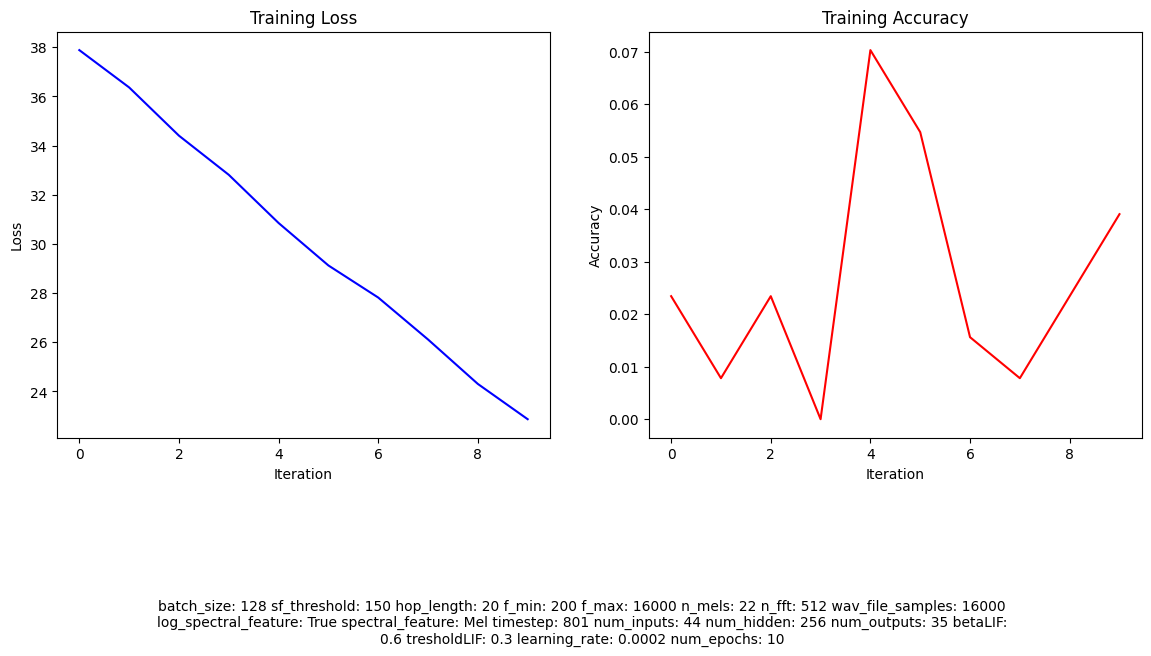

In [29]:
import matplotlib.pyplot as plt
import json
from snntorch import utils
from textwrap import wrap
import glob
import os

# Convert hyperparameters to a formatted string
hyperparams_text = '\n'.join([f'{key}: {value}' for key, value in hyperparams.items()])

# Initialize hyperparameters if not already defined
start_epoch = 0
loss_hist = []
acc_hist = []
test_acc_hist = []
counter = 1
save_every = 2  # Save checkpoint every 2 iterations
plot_every = 10   # Plot and save the figure every 10 iterations

# Create directories for checkpoints and plots if they don't exist
os.makedirs('p_checkpoints', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# Find the latest checkpoint file in the 'checkpoints' folder
checkpoint_files = sorted(glob.glob('p_checkpoints/checkpoint_*.pth'), key=os.path.getmtime)
if checkpoint_files:
    latest_checkpoint = checkpoint_files[-1]
else:
    latest_checkpoint = None

# Attempt to load the latest checkpoint
if latest_checkpoint:
    try:
        checkpoint = torch.load(latest_checkpoint)
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        loss_hist = checkpoint['loss_hist']
        acc_hist = checkpoint['acc_hist']
        test_acc_hist = checkpoint.get('test_acc_hist', [])
        counter = checkpoint['counter']
        print(f"Resuming training from epoch {start_epoch}, iteration {counter}")
    except FileNotFoundError:
        print("No checkpoint found, starting training from scratch.")
else:
    print("No checkpoint found, starting training from scratch.")

# Initialize the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.set_title("Training Loss")
ax2.set_title("Training Accuracy")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")

# Adjust the figure layout to make room for the hyperparameter text
fig.subplots_adjust(bottom=0.3)  # Adjust this value as needed

# Add hyperparameters text to the figure
wrapped_text = '\n'.join(wrap(hyperparams_text, 120))  # Adjust the width as needed
fig.text(0.5, 0.01, wrapped_text, wrap=True, ha='center', fontsize=10)

# Training loop
for epoch in range(start_epoch, num_epochs):
    for i, batch in enumerate(iter(train_loader)):
        data, targets, *_ = batch
        data = data.permute(3, 0, 2, 1).squeeze()
        data = data.to(device)
        targets = targets.to(device)

        net.train()  # Set the network in training mode
        spk_rec = forward_pass(net, data, timestep)  # Forward pass
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss and accuracy
        loss_hist.append(loss_val.item())
        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        # Update the plot and save the figure
        if counter % plot_every == 0:
            ax1.clear()
            ax2.clear()
            ax1.set_title("Training Loss")
            ax2.set_title("Training Accuracy")
            ax1.set_xlabel("Iteration")
            ax1.set_ylabel("Loss")
            ax2.set_xlabel("Iteration")
            ax2.set_ylabel("Accuracy")
            ax1.plot(loss_hist, color='blue')
            ax2.plot(acc_hist, color='red')
            fig.savefig(f'plots/training_plot_epoch_{epoch}_iter_{counter}.png')  # Save the plot

        print(f"\rEpoch {epoch}, Iteration {i} Train Loss: {loss_val.item():.2f} Accuracy: {acc*100:.2f}", end="")

        if counter % save_every == 0:
            # Save checkpoint every `save_every` iterations
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_hist': loss_hist,
                'acc_hist': acc_hist,
                'test_acc_hist': test_acc_hist,
                'counter': counter
            }
            torch.save(checkpoint, f'p_checkpoints/checkpoint_iter_{counter}.pth')
            print(f"\nCheckpoint saved at iteration {counter}.")

        if counter % len(train_loader) == 0:
            with torch.no_grad():
                net.eval()
                test_acc = batch_accuracy(test_loader, net, timestep)
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())
        counter += 1

    # Save checkpoint after each epoch
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_hist': loss_hist,
        'acc_hist': acc_hist,
        'test_acc_hist': test_acc_hist,
        'counter': counter
    }
    torch.save(checkpoint, f'p_checkpoints/checkpoint_epoch_{epoch}.pth')

    # Delete iteration checkpoints after saving the epoch checkpoint
    for ckpt_file in glob.glob('p_checkpoints/checkpoint_iter_*.pth'):
        os.remove(ckpt_file)

    # Save the plot after each epoch
    fig.savefig(f'plots/training_plot_epoch_{epoch}.png')

# Save the final training plot
fig.savefig('plots/final_training_plot.png')
plt.close(fig)  # Close the plot to free up resources

# Save the data to a JSON file
training_data = {
    'loss_hist': loss_hist,
    'acc_hist': acc_hist,
    'test_acc_hist': test_acc_hist
}
with open('training_data.json', 'w') as f:
    json.dump(training_data, f)


##### Save with this if you stop teaching:

END OF NET

#### function that loads a .pth file and prints its contents:

In [ ]:
import torch

def print_checkpoint_contents(checkpoint_path):
    """
    Load a checkpoint file (.pth) and print its contents.

    Args:
    - checkpoint_path (str): Path to the checkpoint file.

    Returns:
    - None
    """
    try:
        # Load the checkpoint file
        checkpoint = torch.load(checkpoint_path)
        
        # Print all the keys in the checkpoint
        print("Checkpoint Keys:")
        print(checkpoint.keys())

        # Optionally, print the values for each key
        for key, value in checkpoint.items():
            if isinstance(value, dict):
                print(f"\nKey: {key} -> Dictionary with {len(value)} items")
                for sub_key in value.keys():
                    if isinstance(value[sub_key], torch.Tensor):
                        print(f"  Subkey: {sub_key}, Shape: {value[sub_key].shape}")
                    else:
                        print(f"  Subkey: {sub_key}, Value: {value[sub_key]}")
            else:
                print(f"\nKey: {key} -> Value: {value}")

    except FileNotFoundError:
        print(f"Checkpoint file not found: {checkpoint_path}")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")

# Example usage
print_checkpoint_contents('p_checkpoints/checkpoint_iter_1062.pth')  # Replace with your .pth file path


#### change epoch number:

In [38]:
import torch

def change_epoch_in_checkpoint(checkpoint_path, new_epoch):
    """
    Load a checkpoint file, change the epoch number, and save it back.

    Args:
    - checkpoint_path (str): Path to the checkpoint file.
    - new_epoch (int): The new epoch number to set.

    Returns:
    - None
    """
    try:
        # Load the checkpoint file
        checkpoint = torch.load(checkpoint_path)

        # Change the epoch number
        if 'epoch' in checkpoint:
            print(f"Old epoch number: {checkpoint['epoch']}")
            checkpoint['epoch'] = new_epoch
            print(f"New epoch number set to: {checkpoint['epoch']}")
        else:
            print("No 'epoch' key found in the checkpoint.")

        # Save the modified checkpoint back to the same file
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved with new epoch number: {new_epoch}")

    except FileNotFoundError:
        print(f"Checkpoint file not found: {checkpoint_path}")
    except Exception as e:
        print(f"Error modifying checkpoint: {e}")

# Example usage
change_epoch_in_checkpoint('p_checkpoints/checkpoint_iter_1144.pth', 5)  # Replace with your .pth file path and desired epoch number


Old epoch number: 7
New epoch number set to: 5
Checkpoint saved with new epoch number: 5


/tmp/ipykernel_865/1819485265.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [2]:
import torch
from torch.utils.data import DataLoader
from ipywidgets import interact, IntSlider

# Function to reinitialize DataLoader with a new batch size
def update_batch_size(new_batch_size):
    global train_loader, test_loader
    
    # Reinitialize train_loader with the new batch size
    train_loader = DataLoader(
        train_set,
        batch_size=new_batch_size,
        shuffle=True,
        collate_fn=lambda batch: custom_collate_fn(
            batch, 
            spectral_feature=spectral_feature,
            hop_length=hop_length, 
            n_mels=n_mels, 
            f_min=f_min, 
            f_max=f_max,
            log_spectral_feature=log_spectral_feature,
            threshold=sf_threshold
        )
    )
    
    # Reinitialize test_loader with the new batch size
    test_loader = DataLoader(
        test_set,
        batch_size=new_batch_size,
        shuffle=False,
        collate_fn=lambda batch: custom_collate_fn(
            batch, 
            spectral_feature=spectral_feature,
            hop_length=hop_length, 
            n_mels=n_mels, 
            f_min=f_min, 
            f_max=f_max,
            log_spectral_feature=log_spectral_feature,
            threshold=sf_threshold
        )
    )
    
    print(f"Batch size updated to: {new_batch_size}")

# Implement a slider to select batch size
interact(update_batch_size, new_batch_size=IntSlider(min=32, max=512, step=32, value=batch_size))


NameError: name 'batch_size' is not defined